In [1]:
#import functions
import numpy as np
from numpy import linalg

import cv2 as cv
import scipy
from scipy import signal

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl

import os
import shutil

from utils import resize_percent, edge_detect, count_gray_levels, fill
# from utils import show_image

In [2]:
#cross correlation function

def cross_correlation (frNum, path_to_images, pixel, kernel, x_disp=False, y_disp=False):
    image_1_name = os.fsdecode(os.listdir(path_to_images)[0])
    image_1 = cv.imread(path_to_images + f'{image_1_name}', cv.IMREAD_GRAYSCALE)
    corr_full_x = np.zeros([image_1.shape[1], frNum])
    corr_full_y = np.zeros([image_1.shape[0], frNum])
    k=0
    while k<frNum:
        image_name = str(k) + '.jpg'
        image_next = cv.imread(path_to_images+f'{image_name}', cv.IMREAD_GRAYSCALE)
        if x_disp:
            arr_1 = np.ones([kernel,]) * image_1[pixel[0], pixel[1]]
            corr = signal.correlate(image_next[pixel[0], :], arr_1, mode='same')
            corr = np.reshape(cv.normalize(corr, None, 1, 256, cv.NORM_MINMAX), (image_1.shape[1],)) #normalization added
            corr_full_x[:, k] = corr
        if y_disp:
            arr_1 = np.ones([kernel,]) * image_1[pixel[0], pixel[1]]
            corr = signal.correlate(image_next[:, pixel[1]], np.transpose(arr_1), mode='same')
            corr = np.reshape(cv.normalize(corr, None, 1, 256, cv.NORM_MINMAX), (image_1.shape[0],)) #normalization added
            corr_full_y[:, k] = corr          
        k+=1
    
    return corr_full_x, corr_full_y

10
[[166.         136.          96.625       61.          32.875
   31.           1.           1.          15.16666667   1.        ]
 [166.         151.         112.5625      76.          48.8125
   46.          16.           1.           1.           1.        ]
 [181.         166.         112.5625      91.          48.8125
   46.          16.          15.16666667  15.16666667  15.16666667]
 [196.         196.         144.4375      91.          64.75
   61.          31.          29.33333333  15.16666667  15.16666667]
 [196.         196.         160.375      121.          96.625
   76.          46.          29.33333333  15.16666667  15.16666667]
 [211.         211.         160.375      136.         112.5625
   91.          46.          43.5         29.33333333  29.33333333]
 [226.         211.         176.3125     136.         128.5
   91.          61.          57.66666667  29.33333333  29.33333333]
 [226.         211.         176.3125     151.         128.5
   91.          61.        

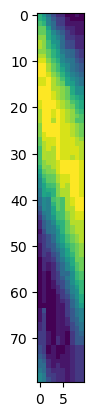

In [274]:
# implement slope measurement for one pixel
# 100x100 pixels
#iterate through each pixel to get a correlation result
frNum = 10
path_to_images = 'sim_2perc_crop/'
# path_to_images = 'sim_1perc_crop/'
# path_to_images = 'sim_05perc_crop/'
kernel = 1
threshold_bin = 0

pixel_x = 4
pixel_y = 0
pixel_array = []
for x in range(0, pixel_x + 1):
     for y in range(0, pixel_y + 1):
        pixel = [pixel_x, pixel_y]
pixel_array.append(pixel)         
         
#corr_full_y is 100x29 matrix which represents one pixel      
_, corr_full_y = cross_correlation(frNum, path_to_images, pixel_array[0], kernel, x_disp=False, y_disp=True)

plt.imshow(corr_full_y)
print(corr_full_y.shape[1])
print(corr_full_y)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1.

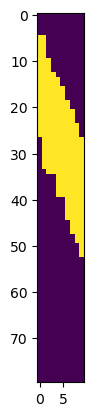

In [275]:
#clean version
T=200
image = np.copy(corr_full_y)
image[corr_full_y<T] = 0
image[corr_full_y>=T] = 1
plt.imshow(image)
print(image)

In [276]:
# Save the Numpy array as Image
image_filename = "image0_2perc.jpeg"
i=0
saved_image = plt.imsave(fname=image_filename, arr=image)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1.

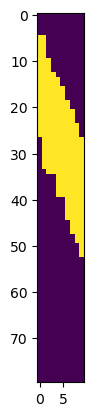

In [277]:
img = cv.imread(filename=image_filename, flags=cv.IMREAD_GRAYSCALE)
plt.imshow(image)
print(image)

[[ 31  30  29  29  29  30  30  30  30  30]
 [ 30  30  29  29  29  30  30  30  30  30]
 [ 30  30  30  30  29  29  30  29  30  30]
 [ 39  37  33  30  29  29  29  29  29  30]
 [ 78  68  46  32  29  29  29  29  29  30]
 [142 118  68  36  30  30  30  29  30  30]
 [183 150  82  40  32  30  30  29  29  30]
 [194 159  86  41  31  30  30  30  30  30]
 [195 162  90  43  31  30  31  30  30  30]
 [198 171 108  55  34  30  29  30  30  30]
 [207 190 137  73  38  30  29  30  30  30]
 [212 201 157  87  42  32  31  30  30  30]
 [213 207 174 111  58  37  33  31  30  30]
 [215 213 196 152  95  51  34  31  30  30]
 [216 215 210 187 137  75  40  31  30  30]
 [215 215 213 204 168 104  53  34  30  30]
 [215 214 214 210 190 137  72  39  31  30]
 [216 215 214 213 202 158  88  44  32  30]
 [216 215 214 214 208 174 109  54  33  30]
 [215 215 214 215 213 193 141  76  40  32]
 [216 215 215 215 215 205 169 105  54  37]
 [216 215 215 215 215 212 191 137  72  46]
 [214 214 216 216 215 215 202 157  88  55]
 [213 213 2

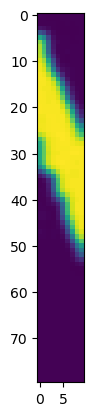

In [278]:
img_bl = cv.GaussianBlur(src=img, ksize=(7, 7), sigmaX=1)
plt.imshow(img_bl)
print(img_bl)
max_gray_level_img = count_gray_levels(img_bl)

[[255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [  0   0 255 255 255 255 255 255 255 255]
 [  0   0 255 255 255 255 255 255 255 255]
 [  0   0 255 255 255 255 255 255 255 255]
 [  0   0 255 255 255 255 255 255 255 255]
 [  0   0   0 255 255 255 255 255 255 255]
 [  0   0   0 255 255 255 255 255 255 255]
 [  0   0   0 255 255 255 255 255 255 255]
 [  0   0   0   0 255 255 255 255 255 255]
 [  0   0   0   0 255 255 255 255 255 255]
 [  0   0   0   0   0 255 255 255 255 255]
 [  0   0   0   0   0   0 255 255 255 255]
 [  0   0   0   0   0   0 255 255 255 255]
 [  0   0   0   0   0   0 255 255 255 255]
 [  0   0   0   0   0   0   0 255 255 255]
 [  0   0   0   0   0   0   0 255 255 255]
 [  0   0   0   0   0   0   0   0 255 255]
 [  0   0   0   0   0   0   0   0 255 255]
 [  0   0   0   0   0   0   0   0 255 255]
 [  0   0  

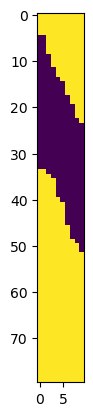

In [279]:
GRAY_LEVEL_01 = 100
img_th = cv.inRange(src=img_bl, lowerb=0, upperb=GRAY_LEVEL_01)
plt.imshow(img_th)
print(img_th)

[[255 255 255 ... 255   0   0]
 [255 255 255 ... 255 255   0]
 [255 255 255 ... 255 255 255]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


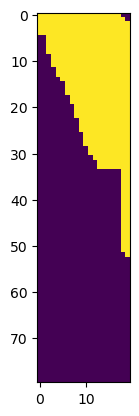

In [258]:
cnts = cv.findContours(img_th, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cnts = sorted(cnts, key=cv.contourArea, reverse=True)

# img_emb = np.zeros((img_th.shape), np.uint8)
img_emb = np.copy(img_th)
(x, y, w, h) = cv.boundingRect(cnts[0])
area_max = w*h
for c in cnts:
    (x, y, w, h) = cv.boundingRect(c)
    cnt_area = w*h
    if cnt_area < area_max:
        img_emb[y:y+h, x:x+w] = 0
plt.imshow(img_emb)
print(img_emb)

[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0  

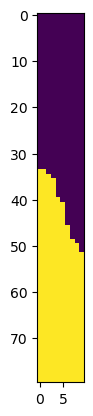

In [280]:
nlabels, labels, stats, centroids = cv.connectedComponentsWithStats(img_th, None, None, None, 8, cv.CV_32S)
areas = stats[1:, cv.CC_STAT_AREA]
area_max1_idx = np.argmax(areas)
area_max2_idx = np.argmax(np.delete(areas, area_max1_idx))
img_emb = np.zeros((labels.shape), np.uint8)
img_emb[labels == area_max1_idx + 1] = 255
plt.imshow(img_emb)
print(img_emb)

[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0  

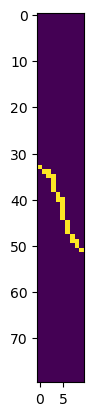

In [281]:
WHITE_LEVEL = 255
img_ed = cv.Canny(image=img_emb, threshold1=WHITE_LEVEL//2, threshold2=WHITE_LEVEL, apertureSize=3, L2gradient=True)
plt.imshow(img_ed)
print(img_ed)

[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0  

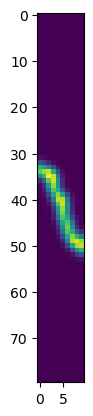

In [282]:
img_bl = cv.GaussianBlur(src=img_ed, ksize=(7, 7), sigmaX=1)
plt.imshow(img_bl)
print(img_bl)

[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0  

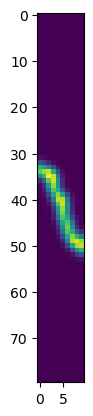

In [283]:
img_line = img_bl.copy()
plt.imshow(img_line)
print(img_line) 

slope is: 76.6075022462489 degrees


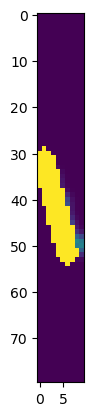

In [293]:
img_line = img_bl.copy()
lines = cv.HoughLinesP(image=img_line, rho=1, theta=np.pi/180, threshold=20, minLineLength=10, maxLineGap=5) #2percent
# lines = cv.HoughLinesP(image=img_line, rho=1, theta=np.pi/180, threshold=25, minLineLength=10, maxLineGap=5) #1prcnt
# lines = cv.HoughLinesP(image=img_line, rho=1, theta=np.pi/180, threshold=25, minLineLength=10, maxLineGap=5) #05prcnt
points = []
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if 0 <= 180*np.arctan2(abs(y2-y1), abs(x2-x1))/np.pi <= 90:
            points = [x1, y1, x2, y2]
            cv.line(img_line, (x1, y1), (x2, y2), (255, 0, 0), 3)
            break
    angle = 180*np.arctan2(abs(y2-y1), abs(x2-x1))/np.pi
    print(f'slope is: {angle} degrees')
else:
    print("no line detected")
plt.imshow(img_line)
# print(img_line)   